<a href="https://colab.research.google.com/github/uwituzeb/IMDB_sentiment_analysis/blob/main/IMDB_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMDB Movie Reviews Sentiment Analysis**

This project aims to compare the effectiveness of classic ML and Deep Learning  models in text classification. It focuses on building a sentiment analysis model using the IMDB movie reviews dataset.
The goal is to classify reviews as positive or negative using two approaches:
- A traditional machine learning model (Logistic Regression) and,
- A deep learning model (LSTM).

Both models are trained, optimized, and evaluated using key metrics such as accuracy, F1-score, and confusion matrix. Hyperparameter tuning is performed and documented through experiment tables in order to improve mdodel performances.

## Importing The Necessary Libraries & Packages

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
import tensorflow as tf
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [ ]:
# Download nltk data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load IMDB dataset
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Data/IMDB Dataset.csv')

#**Exploring dataset**

In this section, we explore the IMDB dataset using statistics and visualizations to understand our training data better.

In [ ]:
# Inspecting the first few rows of the dataset to understand its structure.
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# first review in first row
df.loc[0, 'review']

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
# Summary of the dataset
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
df.info() # From here we can see there are no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
print(df.duplicated().sum())

418


In [ ]:
df.shape

(50000, 2)

## Key Findings from Initial Exploration

- Balanced Classes: The dataset contains exactly 25,000 positive and 25,000 negative reviews, ensuring there is no class imbalance issue during model training.

- No Missing Values: A check for null values confirmed that there are no missing entries in either the review or sentiment columns, which simplifies preprocessing. However, duplicated were identified.

These basic checks confirm that the dataset is balanced, and ready for further exploration and preprocessing.

## Visualizations For Further Exploration

Visualizations are used to uncover patterns and insights in review lengths, word frequencies, and sentiment distributions. These insights guide preprocessing decisions and highlight key characteristics of the text data relevant for model development.

In [ ]:
# transform target data to numerical format
df['sentiment'] = df['sentiment'].replace({'positive': 1, 'negative': 0})
df.head()

<ipython-input-35-25fc52e59ec5>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace({'positive': 1, 'negative': 0})


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


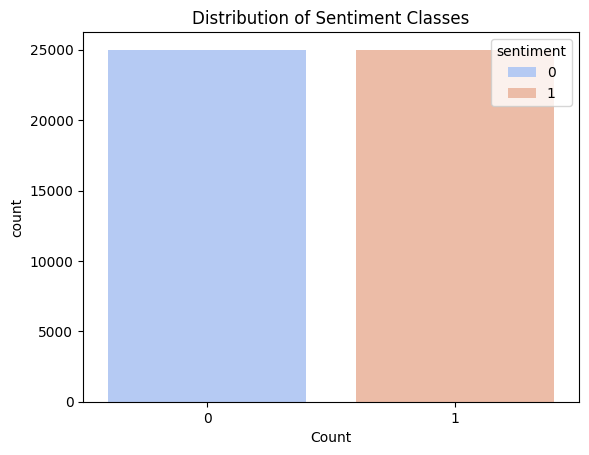

In [ ]:
# sentiment class distribution

sns.countplot(data=df, x='sentiment', palette='coolwarm', hue='sentiment')
plt.title("Distribution of Sentiment Classes")
plt.xlabel("Sentiment")
plt.xlabel("Count")
plt.show()

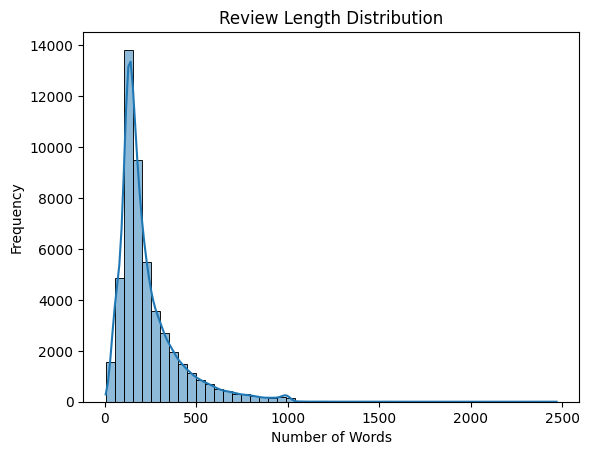

In [ ]:
# Checking review length distribution

df['review_length'] = df['review'].apply(lambda x: len(x.split()))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Review Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

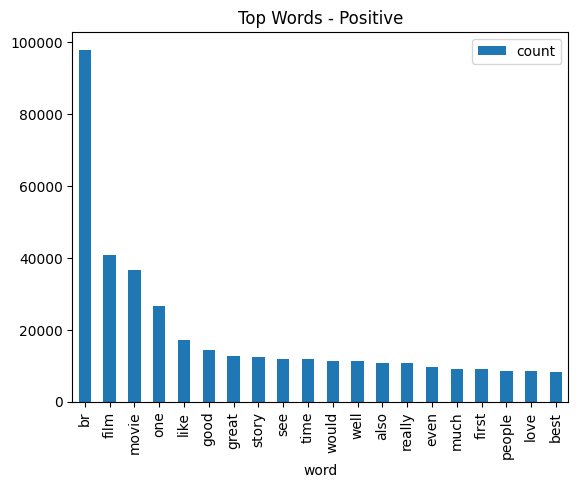

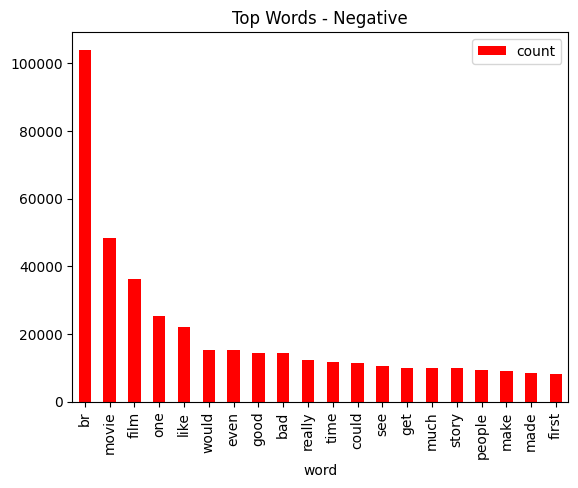

In [ ]:
# plotting bar charts for the common words in each sentiment

stop_words = set(stopwords.words('english'))

def get_top_words(texts, n=20):
    words = []
    for review in texts:
        tokens = word_tokenize(str(review).lower())
        words += [word for word in tokens if word.isalpha() and word not in stop_words]
    return Counter(words).most_common(n)

top_pos = get_top_words(df[df['sentiment'] == 1]['review'])
top_neg = get_top_words(df[df['sentiment'] == 0]['review'])


# Convert to DataFrame and plot
if top_pos:
    pd.DataFrame(top_pos, columns=['word', 'count']).plot.bar(x='word', y='count', title='Top Words - Positive')
    plt.show()
else:
    print("No positive words found to plot.")

if top_neg:
    pd.DataFrame(top_neg, columns=['word', 'count']).plot.bar(x='word', y='count', title='Top Words - Negative', color='red')
    plt.show()
else:
    print("No negative words found to plot.")

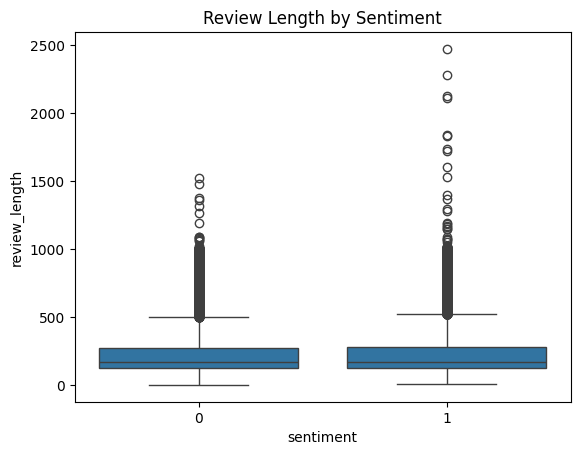

In [ ]:
# Visualizing how the length of reviews varies by sentiment class

sns.boxplot(x='sentiment', y='review_length', data=df)
plt.title('Review Length by Sentiment')
plt.show()

## Findings from Visualizations

- Sentiment Distribution: A bar chart confirmed a perfectly balanced dataset, with an equal number of positive and negative reviews.

- Review Lengths: Histograms revealed that most reviews range between 100 to 300 words. This informed padding/truncation decisions for deep learning models.

### **Word Clouds**:

- The positive reviews word cloud showed terms like "great", "love", and "amazing", indicating strong emotional language.

- The negative reviews word cloud highlighted words such as "bad", "worst", and "boring", reflecting dissatisfaction.

### **Most Frequent Words:**

- In positive reviews, frequently occurring words included "movie", "good", and "like".

- In negative reviews, common terms were "movie", "bad", and "even".

- Review Length by Sentiment: A box plot suggested that positive reviews tend to be slightly longer than negative reviews, though the difference isn’t substantial.

These insights were crucial in guiding preprocessing, feature extraction, and model input strategies.

# **Data Preprocessing**

In [ ]:
# Drop duplicates
df.drop_duplicates(inplace=True)
print(df.duplicated().sum())


0


In [ ]:
# preprocess to convert to lowercase, remove html tags, punctuation and special characters
# Remove leading and trailing whitespace and normalize whitespaced to single space
text = df['review']
text = text.str.lower()
text = text.str.replace('<br />', '', regex=False)
text = text.str.replace(r'[^\w\s]', '', regex=True)
text = text.str.replace(r'\@w+\#', '', regex=True)
text = text.str.strip()
text = text.str.replace(r'\s+', ' ', regex=True)

#remove stop words
stop_words = set(stopwords.words('english'))
text = text.apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))
df['review'] = text
df.head(10)

,review,sentiment,review_length
0,one reviewers mentioned watching 1 oz episode ...,1,307
1,wonderful little production filming technique ...,1,162
2,thought wonderful way spend time hot summer we...,1,166
3,basically theres family little boy jake thinks...,0,138
4,petter matteis love time money visually stunni...,1,230
5,probably alltime favorite movie story selfless...,1,119
6,sure would like see resurrection dated seahunt...,1,150
7,show amazing fresh innovative idea 70s first a...,0,174
8,encouraged positive comments film looking forw...,0,130
9,like original gut wrenching laughter like movi...,1,33


In [ ]:
df.review[0]

'one reviewers mentioned watching 1 oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle 

# Model Features Encoding And Building

In [ ]:
# Split dataset into training and test data
X = df['review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Convert text data to TF-IDF feature vectors and transform train and test data
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## Why TF-IDF Vectorization?

We used TF-IDF (Term Frequency–Inverse Document Frequency) to convert text data into numerical features for our traditional machine learning model.

- TF-IDF was chosen because it balances word frequency with word uniqueness, helping the model focus on words that are meaningful for classification.

- Unlike simple Bag-of-Words methods, TF-IDF reduces the weight of common words (like “movie” or “film”) that appear across many reviews and emphasizes more informative words that better distinguish sentiment. This helps improve the model’s ability to identify patterns specific to positive or negative reviews.

- limiting the feature set to the top 5,000 terms (or experimented with more) helped to reduce dimensionality and improve training speed while retaining relevant information.

- TF-IDF is particularly effective for linear models also like Logistic Regression, which benefit from sparse, high-dimensional feature representations where each word contributes independently to the final prediction.

# Classic Model

In [ ]:
# Train the logistic regression model
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

# Evaluation of model performance
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      4939
           1       0.88      0.90      0.89      4978

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917

[[4313  626]
 [ 500 4478]]


<Axes: >

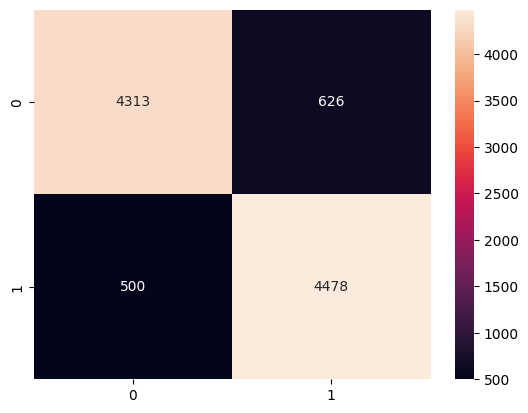

In [ ]:
# heatmap of the confusion matrix
# The diagonal values are correct predictions; off-diagonal are errors
# Our false positive and false negative are relatively low therefore our model performs well overall
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d')

### Tuning The Classic Model

In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200]
}

tuned_model = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', verbose=1)
tuned_model.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200],
                         'penalty': ['l2'], 'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

In [ ]:
best_lr = tuned_model.best_estimator_

In [ ]:
y_pred_tuned= best_lr.predict(X_test_tfidf)

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned))

# Precision, Recall, F1
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned, target_names=['Negative', 'Positive']))



Accuracy: 0.8866592719572451

Confusion Matrix:
[[4311  628]
 [ 496 4482]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.87      0.88      4939
    Positive       0.88      0.90      0.89      4978

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



<Axes: >

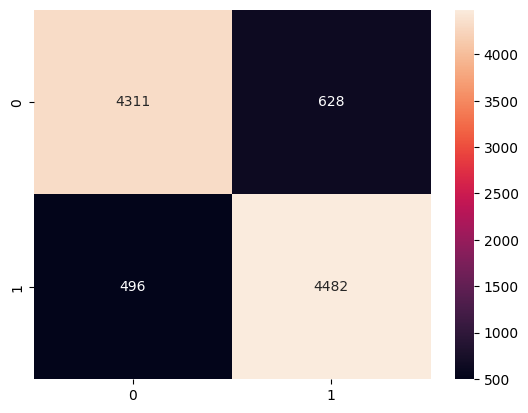

In [ ]:
# heatmap of the confusion matrix
# The diagonal values are correct predictions; off-diagonal are errors
# Our false positive and false negative are relatively low therefore our model performs well overall
cm = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm, annot=True, fmt='d')

### Summary of Findings – Logistic Regression Tuning
After applying hyperparameter tuning to the Logistic Regression model using GridSearchCV, we observed that the model's performance remained nearly identical to the untuned version. This suggests that the default parameters of Logistic Regression were already well-suited for our dataset and TF-IDF features.

# Deep Learning Model - LSTM

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization and padding
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')


In [ ]:
# Model architecture
from tensorflow.keras.layers import Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping
embedding_dim = 64

model = Sequential([
    Embedding(input_dim=500, output_dim=embedding_dim, input_length=max_length),
    LSTM(62, return_sequences=True),
    Dropout(0.4),
    LSTM(32),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Model training
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(X_train_pad, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_test_pad, y_test),
                    callbacks=[early_stop])

# Evaluation
y_pred_lstm = (model.predict(X_test_pad) > 0.5).astype(int)

print("\nLSTM Model Results:")
print(classification_report(y_test, y_pred_lstm))
print(confusion_matrix(y_test, y_pred_lstm))


Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 203s 316ms/step - accuracy: 0.5063 - loss: 0.6932 - val_accuracy: 0.5149 - val_loss: 0.6881
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 197s 309ms/step - accuracy: 0.5338 - loss: 0.6804 - val_accuracy: 0.4907 - val_loss: 0.6937
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 201s 308ms/step - accuracy: 0.5073 - loss: 0.6961 - val_accuracy: 0.6569 - val_loss: 0.6641
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 190s 307ms/step - accuracy: 0.7361 - loss: 0.5527 - val_accuracy: 0.7670 - val_loss: 0.4812
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 201s 306ms/step - accuracy: 0.7884 - loss: 0.4755 - val_accuracy: 0.7752 - val_loss: 0.5013
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 191s 309ms/step - accuracy: 0.8006 - loss: 0.4491 - val_accuracy: 0.7940 - val_loss: 0.4652
Epoch 7/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 192s 293ms/step - accuracy: 0.7948 - loss: 0.4753 - val_accuracy: 0.8436 - val_loss: 0.3710
Epoch 8/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 209s 305ms/step - accuracy: 0.8689 -

<Axes: >

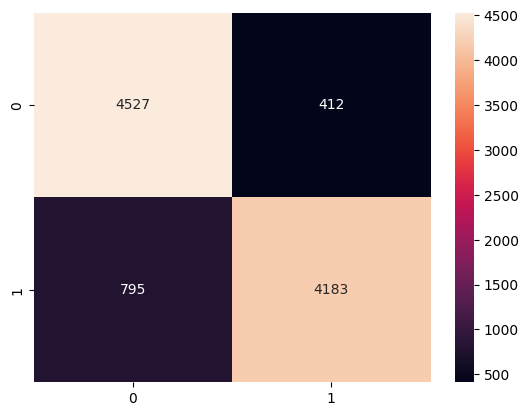

In [ ]:
# Visualization
cm = confusion_matrix(y_test,  y_pred_lstm)
sns.heatmap(cm, annot=True, fmt='d')